In [1]:
import gc
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

In [2]:
BASE = '/kaggle/input/godaddy-microbusiness-density-forecasting/'

In [3]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true != 0) | (y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [4]:
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true != 0) | (y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [5]:
census = pd.read_csv(BASE + 'census_starter.csv')
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [6]:
train = pd.read_csv(BASE + 'train.csv')
reaveal_test = pd.read_csv(BASE + 'revealed_test.csv')
train = pd.concat([train, reaveal_test]).sort_values(by=['cfips', 'first_day_of_month']).reset_index()

test = pd.read_csv(BASE + 'test.csv')
drop_index = (test['first_day_of_month'] == '2022-11-01') | (test['first_day_of_month'] == '2022-12-01')
test = test.loc[~drop_index, :]

sub = pd.read_csv(BASE + 'sample_submission.csv')
coords = pd.read_csv('/kaggle/input/usa-counties-coordinates/cfips_location.csv')
print(train.shape, test.shape, sub.shape)

(128535, 8) (18810, 3) (25080, 2)


In [7]:
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips', 'row_id']).reset_index(drop=True)
raw = raw.merge(coords.drop(columns=["name"]), on="cfips")

raw["state_i1"] = raw['state'].astype('category')
raw['county_i1'] = raw['county'].astype('category')
raw['first_day_of_month'] = pd.to_datetime(raw['first_day_of_month'])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw['dcount'] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['scale'] = (raw['first_day_of_month'] - raw['first_day_of_month'].min()).dt.days
raw['scale']  = raw['scale'].factorize()[0]
raw.tail(5)

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale
147340,NaN,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,-104.567404,43.840315,NaN,NaN,42,3134,50,42
147341,NaN,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,-104.567404,43.840315,NaN,NaN,43,3134,50,43
147342,NaN,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,-104.567404,43.840315,NaN,NaN,44,3134,50,44
147343,NaN,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,-104.567404,43.840315,NaN,NaN,45,3134,50,45
147344,NaN,56045_2023-06-01,56045,Weston County,Wyoming,2023-06-01,NaN,NaN,1,-104.567404,43.840315,NaN,NaN,46,3134,50,46


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
test['first_day_of_month'].unique()

array(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
       '2023-05-01', '2023-06-01'], dtype=object)

In [10]:
raw.loc[raw.dcount == (40), :].reset_index(drop=True)

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale
0,1.0,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475.0,0,-86.642900,32.535142,Alabama,Autauga County,40,0,0,40
1,3.0,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133.0,0,-87.722745,30.727825,Alabama,Baldwin County,40,1,0,40
2,5.0,1005_2022-12-01,1005,Barbour County,Alabama,2022-12-01,1.252272,248.0,0,-85.391068,31.870090,Alabama,Barbour County,40,2,0,40
3,7.0,1007_2022-12-01,1007,Bibb County,Alabama,2022-12-01,1.287240,229.0,0,-87.126814,32.998376,Alabama,Bibb County,40,3,0,40
4,9.0,1009_2022-12-01,1009,Blount County,Alabama,2022-12-01,1.852060,822.0,0,-86.567006,33.980871,Alabama,Blount County,40,4,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,6261.0,56037_2022-12-01,56037,Sweetwater County,Wyoming,2022-12-01,2.876845,922.0,0,-108.879388,41.659762,Wyoming,Sweetwater County,40,3130,50,40
3131,6263.0,56039_2022-12-01,56039,Teton County,Wyoming,2022-12-01,26.314966,5043.0,0,-110.589698,43.934564,Wyoming,Teton County,40,3131,50,40
3132,6265.0,56041_2022-12-01,56041,Uinta County,Wyoming,2022-12-01,4.050703,588.0,0,-110.547405,41.287497,Wyoming,Uinta County,40,3132,50,40
3133,6267.0,56043_2022-12-01,56043,Washakie County,Wyoming,2022-12-01,3.060380,185.0,0,-107.682315,43.904378,Wyoming,Washakie County,40,3133,50,40


<AxesSubplot:xlabel='dcount'>

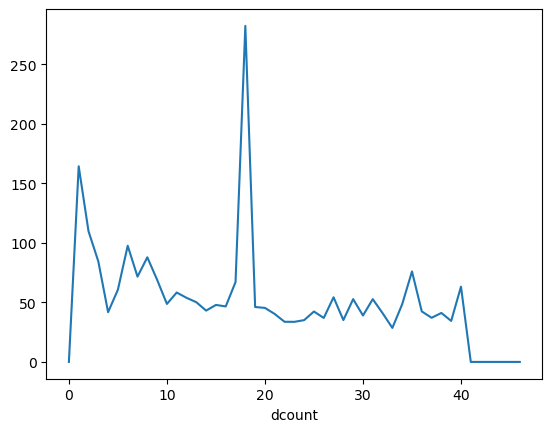

In [11]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}'] == 0), 'dif'] = 0
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

In [12]:
outliers = []
cnt = 0
for o in tqdm(raw['cfips'].unique()):
    indices = (raw['cfips'] == o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp['microbusiness_density'].to_numpy().copy()
    
    for i in range(40, 0, -1):
        thr = 0.2 * np.mean(var[:i])
        difa = abs(var[i] - var[i-1])
        if difa >= thr:
            var[:i] *= var[i] / var[i-1]
            outliers.append(o)
            cnt += 1
    var[0] = var[1] * 0.99
    raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


(552, 903)

<AxesSubplot:xlabel='dcount'>

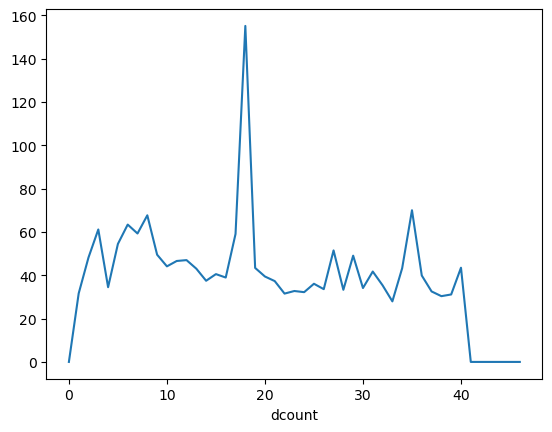

In [13]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}'] == 0), 'dif'] = 0
raw.loc[(raw['microbusiness_density'] > 0) & (raw[f'mbd_lag_{lag}'] == 0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

In [14]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target'] / raw['microbusiness_density'] - 1

raw.loc[raw['cfips'] == 28055, 'target'] = 0.0
raw.loc[raw['cfips'] == 48269, 'target'] = 0.0

raw.iloc[:5, :5]

,index,row_id,cfips,county,state
0,0.0,1001_2019-08-01,1001,Autauga County,Alabama
1,1.0,1001_2019-09-01,1001,Autauga County,Alabama
2,2.0,1001_2019-10-01,1001,Autauga County,Alabama
3,3.0,1001_2019-11-01,1001,Autauga County,Alabama
4,4.0,1001_2019-12-01,1001,Autauga County,Alabama


<AxesSubplot:>

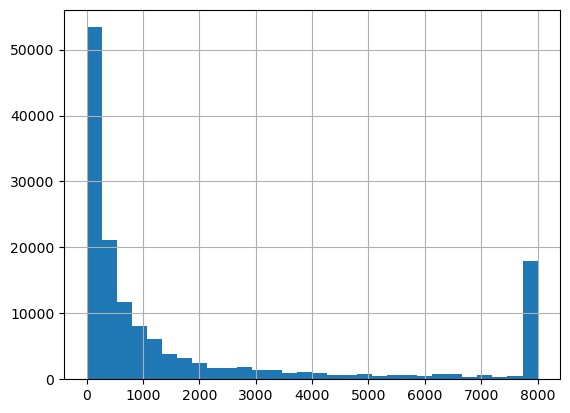

In [15]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw['dcount'] == 40].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)

raw['lastactive'].clip(0, 8000).hist(bins=30)

In [16]:
def build_features(raw, target='microbusiness_density', target_act = 'active_tmp', lags=6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    census_columns = list(census.columns)
    census_columns.remove('cfips')
    
    raw = raw.merge(census, on='cfips', how='left')
    feats += census_columns
    
    co_est = pd.read_csv('/kaggle/input/us-indicator/co-est2021-alldata.csv', encoding='latin-1')
    co_est['cfips'] = co_est['STATE'] * 1000 + co_est['COUNTY']
    co_columns = [
        'SUMLEV',
        'DIVISION',
        'ESTIMATESBASE2020',
        'POPESTIMATE2020',
        'POPESTIMATE2021',
        'NPOPCHG2020',
        'NPOPCHG2021',
        'BIRTHS2020',
        'BIRTHS2021',
        'DEATHS2020',
        'DEATHS2021',
        'NATURALCHG2020',
        'NATURALCHG2021',
        'INTERNATIONALMIG2020',
        'INTERNATIONALMIG2021',
        'DOMESTICMIG2020',
        'DOMESTICMIG2021',
        'NETMIG2020',
        'NETMIG2021',
        'RESIDUAL2020',
        'RESIDUAL2021',
        'GQESTIMATESBASE2020',
        'GQESTIMATES2020',
        'GQESTIMATES2021',
        'RBIRTH2021',
        'RDEATH2021',
        'RNATURALCHG2021',
        'RINTERNATIONALMIG2021',
        'RDOMESTICMIG2021',
        'RNETMIG2021'
    ]
    raw = raw.merge(co_est, on='cfips', how='left')
    feats += co_columns
    return raw, feats

In [17]:
raw, feats = build_features(raw, 'target', 'active', lags=8)
features = ['state_i']
features += feats
features += ['lng', 'lat']
print(features)
raw.loc[raw.dcount==40, features].head(5)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_lag_4', 'act_lag_4', 'mbd_lag_5', 'act_lag_5', 'mbd_lag_6', 'act_lag_6', 'mbd_lag_7', 'act_lag_7', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'mbd_rollmea8_1', 'mbd_rollmea10_1', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021', 'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021', 'SUMLEV', 'DIVISION', 'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021', 'NPOPCHG2020', 'NPOPCHG2021', 'BIRTHS2020', 'BIRTHS2021', 'DEATHS2020', 'DEATHS2021', 'NATURALCHG2020', 'NATU

,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_lag_5,...,GQESTIMATES2020,GQESTIMATES2021,RBIRTH2021,RDEATH2021,RNATURALCHG2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021,lng,lat
40,0,0.008202,12.0,-0.006114,3.0,0.006152,12.0,0.005498,20.0,-0.004107,...,442,442,11.002611,11.545112,-0.542502,0.084766,4.017903,4.102668,-86.642900,32.535142
87,0,-0.000848,-12.0,-0.012221,-187.0,0.002170,-156.0,-0.017601,-412.0,-0.009601,...,2177,2177,9.567474,12.137145,-2.569671,0.266704,28.702422,28.969126,-87.722745,30.727825
134,0,0.004049,1.0,0.012295,4.0,0.020921,9.0,0.008439,11.0,-0.016597,...,2789,2789,10.928526,15.714742,-4.786216,0.039885,-3.908743,-3.868858,-85.391068,31.870090
181,0,0.008811,2.0,-0.008734,0.0,-0.021367,-5.0,0.017391,-1.0,-0.025424,...,2062,2062,10.111857,12.617450,-2.505593,0.089485,13.825503,13.914989,-87.126814,32.998376
228,0,0.008589,7.0,0.002460,9.0,-0.010949,0.0,0.008589,7.0,0.002460,...,449,449,10.650006,13.883950,-3.233945,0.033863,2.370431,2.404294,-86.567006,33.980871


In [18]:
features += ['scale']

In [19]:
coordinates = raw[['lng', 'lat']].to_numpy()

emb_size = 20
precision = 1e6

latlon = np.expand_dims(coordinates, axis=-1)

m = np.exp(np.log(precision)/emb_size)
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1, 1, emb_size)
latlon = latlon * angle_freq
latlon[..., 0::2] = np.cos(latlon[..., 0::2])

In [20]:
def rot(df):
    for angle in [15, 30, 45]:
        df[f'rot_{angle}_x'] = (np.cos(np.radians(angle)) * df['lat']) + (np.sin(np.radians(angle)) * df['lng'])
        df[f'rot_{angle}_y'] = (np.cos(np.radians(angle)) * df['lat']) - (np.sin(np.radians(angle)) * df['lng'])
    return df

raw = rot(raw)

In [21]:
features += ['rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']

In [22]:
def get_model():
    import catboost as cat
    
    cat_model = cat.CatBoostRegressor(
        iterations=800,
        loss_function="MAPE",
        verbose=0,
        grow_policy="SymmetricTree",
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.7,
        max_bin=4096
    )
    
    return cat_model

In [23]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

In [24]:
ACT_THR = 140
ABS_THR = 0
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
VAL = []

for TS in range(39, 40):
    print(TS)
    
    model = get_model()
    
    train_indices = (raw['istest'] == 0) & (raw['dcount'] < TS) & (raw['dcount'] >= 1) & (raw['lastactive'] > ACT_THR) & (raw['lasttarget'] > ABS_THR)
    valid_indices = (raw['istest'] == 0) & (raw['dcount'] == TS)
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
    )
    
    ypred = model.predict(raw.loc[valid_indices, features])
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices, 'k'] = raw.loc[valid_indices, 'k'] * raw.loc[valid_indices, 'microbusiness_density']
    
    lastval = raw.loc[raw['dcount'] == TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw['dcount'] == TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw['dcount'] == (TS + 1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    df.loc[df['lastactive'] <= ACT_THR, 'pred'] = df.loc[df['lastactive'] <= ACT_THR, 'lastval']
    df.loc[df['lastval'] <= ABS_THR, 'pred'] = df.loc[df['lastval'] <= ABS_THR, 'lastval']
    
    raw.loc[raw['dcount'] == (TS + 1), 'ypred'] = df['pred'].to_numpy()
    raw.loc[raw['dcount'] == (TS + 1), 'ypred_last'] = df['lastval'].to_numpy()
    
    print(f'TS: {TS}')
    print('Last Value SMAPE: ', smape(df['microbusiness_density'], df['lastval']))
    print("SMAPE: ", smape(df['microbusiness_density'], df['pred']))
    print()
    
ind = (raw['dcount'] >= 30) & (raw['dcount'] <= 40)
print("SMAPE: ", smape(raw.loc[ind, 'microbusiness_density'], raw.loc[ind, 'ypred']))
print("Last Value SMAPE: ", smape(raw.loc[ind, 'microbusiness_density'], raw.loc[ind, 'ypred_last']))

39
TS: 39
Last Value SMAPE:  nan
SMAPE:  nan

SMAPE:  nan
Last Value SMAPE:  nan


In [25]:
raw.loc[raw['dcount'] == (41), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)

,cfips,microbusiness_density,state,lastactive,mbd_lag_1
0,1001,NaN,Alabama,1475.0,NaN
1,1003,NaN,Alabama,14133.0,NaN
2,1005,NaN,Alabama,248.0,NaN
3,1007,NaN,Alabama,229.0,NaN
4,1009,NaN,Alabama,822.0,NaN
...,...,...,...,...,...
3130,56037,NaN,Wyoming,922.0,NaN
3131,56039,NaN,Wyoming,5043.0,NaN
3132,56041,NaN,Wyoming,588.0,NaN
3133,56043,NaN,Wyoming,185.0,NaN


In [26]:
TS = 40
print(TS)

model0 = get_model()

train_indices = (raw['istest'] == 0) & (raw['dcount'] < TS) & (raw['dcount'] >= 1) & (raw['lastactive'] > ACT_THR) & (raw['lasttarget'] > ABS_THR)
valid_indices = (raw['dcount'] == TS)

model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046)
)
ypred = model0.predict(raw.loc[valid_indices, features])
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices, 'k'] = raw.loc[valid_indices, 'k'] * raw.loc[valid_indices, 'microbusiness_density']

lastval = raw.loc[raw['dcount'] == TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw['dcount'] == TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

df = raw.loc[raw['dcount'] == (TS + 1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)

df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive'] <= ACT_THR, 'pred'] = df.loc[df['lastactive'] <= ACT_THR, 'lastval']
df.loc[df['lastval'] <= ABS_THR, 'pred'] = df.loc[df['lastval'] <= ABS_THR, 'lastval']

raw.loc[raw['dcount'] == (TS + 1), 'ypred'] = df['pred'].to_numpy()
raw.loc[raw['dcount'] == (TS + 1), 'ypred_last'] = df['lastval'].to_numpy()

40


In [27]:
raw[['cfips', 'microbusiness_density', 'dcount', 'ypred', 'ypred_last', 'k']].tail(5)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
147340,56045,NaN,42,NaN,NaN,1.0
147341,56045,NaN,43,NaN,NaN,1.0
147342,56045,NaN,44,NaN,NaN,1.0
147343,56045,NaN,45,NaN,NaN,1.0
147344,56045,NaN,46,NaN,NaN,1.0


In [28]:
raw.loc[raw['cfips'] == 28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips'] == 48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw['dcount'] == 41, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw['istest'] == 1, ['row_id', 'cfips', 'microbusiness_density']].copy()
test

,row_id,cfips,microbusiness_density
41,1001_2023-01-01,1001,NaN
42,1001_2023-02-01,1001,NaN
43,1001_2023-03-01,1001,NaN
44,1001_2023-04-01,1001,NaN
45,1001_2023-05-01,1001,NaN
...,...,...,...
147340,56045_2023-02-01,56045,NaN
147341,56045_2023-03-01,56045,NaN
147342,56045_2023-04-01,56045,NaN
147343,56045_2023-05-01,56045,NaN


In [29]:
test['microbusiness_density'] = test['cfips'].map(dt)

test = test[['row_id', 'microbusiness_density']]
test

,row_id,microbusiness_density
41,1001_2023-01-01,3.485770
42,1001_2023-02-01,3.485770
43,1001_2023-03-01,3.485770
44,1001_2023-04-01,3.485770
45,1001_2023-05-01,3.485770
...,...,...
147340,56045_2023-02-01,1.803249
147341,56045_2023-03-01,1.803249
147342,56045_2023-04-01,1.803249
147343,56045_2023-05-01,1.803249


In [30]:
sample_sub = pd.read_csv(BASE + 'revealed_test.csv')
sub_index = (sample_sub['first_day_of_month'] == '2022-11-01') | (sample_sub['first_day_of_month'] == '2022-12-01')
test1 = pd.concat([sample_sub.loc[sub_index, :].drop([i for i in sample_sub.columns if i != 'row_id' and i != 'microbusiness_density'], axis=1).fillna(2), test])

In [31]:
test1 = test1.fillna(2)

In [32]:
COLS = ['GEO_ID', 'NAME', 'S0101_C01_026E']
df2020 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv',
                     usecols=COLS)
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype(int)
print(df2020.shape)
df2020.head()

(3221, 3)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",42496
2,0500000US01003,"Baldwin County, Alabama",171296
3,0500000US01005,"Barbour County, Alabama",19804
4,0500000US01007,"Bibb County, Alabama",17790
5,0500000US01009,"Blount County, Alabama",44383


In [33]:
df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv',
                     usecols=COLS)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype(int)
print(df2021.shape)
df2021.head()

(3221, 3)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995
4,0500000US01007,"Bibb County, Alabama",17800
5,0500000US01009,"Blount County, Alabama",45201


In [34]:
test1['cfips'] = test1['row_id'].apply(lambda x: int(x.split('_')[0]))
test1.head()

,row_id,microbusiness_density,cfips
0,1001_2022-11-01,3.442677,1001
1,1001_2022-12-01,3.470915,1001
2,1003_2022-11-01,8.257636,1003
3,1003_2022-12-01,8.250630,1003
4,1005_2022-11-01,1.247223,1005


In [35]:
df2020['cfips'] = df2020['GEO_ID'].apply(lambda x: int(x.split('US')[-1]))
adult2020 = df2020.set_index('cfips')['S0101_C01_026E'].to_dict()

df2021['cfips'] = df2021['GEO_ID'].apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips')['S0101_C01_026E'].to_dict()

test1['adult2020'] = test1['cfips'].map(adult2020)
test1['adult2021'] = test1['cfips'].map(adult2021)
test1.head()

,row_id,microbusiness_density,cfips,adult2020,adult2021
0,1001_2022-11-01,3.442677,1001,42496,44438
1,1001_2022-12-01,3.470915,1001,42496,44438
2,1003_2022-11-01,8.257636,1003,171296,178105
3,1003_2022-12-01,8.250630,1003,171296,178105
4,1005_2022-11-01,1.247223,1005,19804,19995


In [36]:
test1['microbusiness_density'] = test1['microbusiness_density'] * test1['adult2020'] / test1['adult2021']
test1 = test1.drop(columns=['adult2020', 'adult2021', 'cfips'])
test1.to_csv('submission.csv', index=False)
test1.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.292227
1,1001_2022-12-01,3.319231
2,1003_2022-11-01,7.941945
3,1003_2022-12-01,7.935207
4,1005_2022-11-01,1.235309
